In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from convnext import ConvNeXt
from fastprogress.fastprogress import master_bar, progress_bar
from torchvision.transforms import RandomResizedCrop, CenterCrop, Resize, RandomHorizontalFlip, Compose, ToTensor
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

/home/server/danjacobellis/BF/convnext.py:159: UserWarning: Overwriting convnext_tiny in registry with convnext.convnext_tiny. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def convnext_tiny(pretrained=False,in_22k=False, **kwargs):
/home/server/danjacobellis/BF/convnext.py:168: UserWarning: Overwriting convnext_small in registry with convnext.convnext_small. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def convnext_small(pretrained=False,in_22k=False, **kwargs):
/home/server/danjacobellis/BF/convnext.py:177: UserWarning: Overwriting convnext_base in registry with convnext.convnext_base. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def convnext_base(pretrained=False, in_22k=False, **kwargs):
/home/server/danjacobellis/BF/convnext.py:186: UserWarning: Overwriting convnext_large in 

In [2]:
train_dataset = load_dataset("frgfm/imagenette","full_size",split="train")
valid_dataset = load_dataset("frgfm/imagenette","full_size",split="validation")
rgb_train = train_dataset.filter(lambda s: s["image"].mode == "RGB").with_format("torch")
rgb_valid = valid_dataset.filter(lambda s: s["image"].mode == "RGB").with_format("torch")

In [3]:
def custom_collate_fn(batch):
    train_transforms = Compose(
        [
            RandomResizedCrop(256, scale=(0.5,1.0), ratio=(0.8, 1.25)),
            RandomHorizontalFlip(),
        ]
    )
    images = torch.stack([train_transforms(item['image'].permute(2,0,1).to(torch.float)/255) for item in batch])
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.int64)
    return images, labels

val_transforms = Compose(
    [
        Resize(256,antialias=True),
        CenterCrop(256),
    ]
)

In [4]:
classifier = ConvNeXt(in_chans=3,
                      num_classes=10,
                      depths=[3, 3, 9, 3],
                      dims=[96, 192, 384, 768],
                      drop_path_rate=0.,
                      layer_scale_init_value=1e-6,
                      head_init_scale=1.).cuda()

In [5]:
epochs = 90
batch_size = 96
accumulation_steps = 96//batch_size

loss_function = nn.CrossEntropyLoss()
optimizer = AdamW(classifier.parameters(), lr=0.005, weight_decay=1e-4)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

train_loss = []
test_loss = []
val_accuracy = []

Epoch: 1, Accuracy: 0.1017


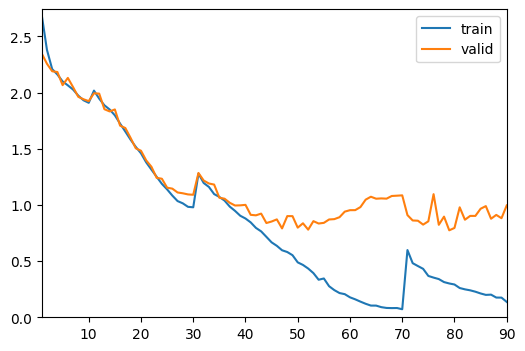

/home/server/.local/lib/python3.10/site-packages/fastprogress/fastprogress.py:206: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  if x_bounds is not None: self.graph_ax.set_xlim(*x_bounds)


Epoch: 2, Accuracy: 0.1922
Epoch: 3, Accuracy: 0.1981
Epoch: 4, Accuracy: 0.1828
Epoch: 5, Accuracy: 0.2347
Epoch: 6, Accuracy: 0.2207
Epoch: 7, Accuracy: 0.2596
Epoch: 8, Accuracy: 0.3032
Epoch: 9, Accuracy: 0.3117
Epoch: 10, Accuracy: 0.3185
Epoch: 11, Accuracy: 0.2811
Epoch: 12, Accuracy: 0.2907
Epoch: 13, Accuracy: 0.3532
Epoch: 14, Accuracy: 0.3563
Epoch: 15, Accuracy: 0.3664
Epoch: 16, Accuracy: 0.4168
Epoch: 17, Accuracy: 0.4222
Epoch: 18, Accuracy: 0.4466
Epoch: 19, Accuracy: 0.4886
Epoch: 20, Accuracy: 0.4953
Epoch: 21, Accuracy: 0.5272
Epoch: 22, Accuracy: 0.5501
Epoch: 23, Accuracy: 0.5877
Epoch: 24, Accuracy: 0.5926
Epoch: 25, Accuracy: 0.6188
Epoch: 26, Accuracy: 0.6240
Epoch: 27, Accuracy: 0.6330
Epoch: 28, Accuracy: 0.6393
Epoch: 29, Accuracy: 0.6395
Epoch: 30, Accuracy: 0.6419
Epoch: 31, Accuracy: 0.5812
Epoch: 32, Accuracy: 0.5892
Epoch: 33, Accuracy: 0.6138
Epoch: 34, Accuracy: 0.6159
Epoch: 35, Accuracy: 0.6486
Epoch: 36, Accuracy: 0.6556
Epoch: 37, Accuracy: 0.6616


In [6]:
mb = master_bar(range(1, epochs + 1))

for epoch in mb:
    
    dataloader_train = DataLoader(rgb_train, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=12, collate_fn=custom_collate_fn)
    dataloader_valid = DataLoader(rgb_valid, batch_size=1, shuffle=False, drop_last=False)

    # Training
    classifier.train()
    optimizer.zero_grad()
    running_loss = 0.0
    for i_batch, (x, target) in enumerate(progress_bar(dataloader_train, parent=mb)):
        x = x.cuda()
        outputs = classifier(x)
        loss = loss_function(outputs, target.cuda())
        loss.backward()
        print(loss.item(), end='\r')
        running_loss += loss.item()

        if (i_batch + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    train_epoch_loss = running_loss / len(dataloader_train)
    train_loss.append(train_epoch_loss)
    
    # Validation
    classifier.eval()
    running_loss_val = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs in dataloader_valid:
            x = inputs['image'].permute(0,3,1,2).to(torch.float)/255
            x = val_transforms(x).cuda()
            targets = inputs['label'].to(torch.int64).cuda()
            outputs = classifier(x)
            loss = loss_function(outputs, targets)
            running_loss_val += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets).sum().item()
            total_predictions += targets.size(0)
    val_epoch_loss = running_loss_val / len(dataloader_valid)
    test_loss.append(val_epoch_loss)
    epoch_accuracy = correct_predictions / total_predictions
    print(f'Epoch: {epoch}, Accuracy: {epoch_accuracy:.4f}')
    val_accuracy.append(epoch_accuracy)
    graphs = [
        [range(1, epoch + 1), train_loss],  # Training Loss
        [range(1, epoch + 1), test_loss],  # Validation Loss
    ]
    x_bounds = [1, epoch]
    y_bounds = [min(min(train_loss + test_loss) - 0.05, 0), max(max(train_loss + test_loss) + 0.05, 1)]
    mb.update_graph(graphs, x_bounds, y_bounds)
    scheduler.step()

In [7]:
checkpoint_filename = f'convnext_imagenette_e{epoch}.pt'
checkpoint = {
    'model_state_dict': classifier.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'epoch': epoch,
    'train_loss': train_loss,
    'test_loss': test_loss,
    'val_accuracy': val_accuracy
}
torch.save(checkpoint, checkpoint_filename)